In [1]:
# %load defaults.ipy
# %load defaults.ipy
from numpy import *
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 200
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import PIL



def writeMetadata(filename, data):
    im = PIL.Image.open(filename)
    
    meta = PIL.PngImagePlugin.PngInfo()

    for key in data.keys():
        meta.add_text(key, data[key])
    im.save(filename, "png", pnginfo=meta)
    
def showAndSave(name):
    fig = plt.gcf()
    ax = plt.gca()
    ax.text(0.95, 0.01, 'By Kjetil Olsen Lye\nkjetil.o.lye@gmail.com',
         fontsize=3, color='gray',
         ha='right', va='bottom', alpha=0.5, transform=ax.transAxes)

    matplotlib2tikz.save(name + '.tikz',
           figureheight = '\\figureheight',
           figurewidth = '\\figurewidth')
    
    savenamepng = name + '.png'
    plt.savefig(savenamepng)
    
    writeMetadata(savenamepng, {'Copyright' : 'Copyright, Kjetil Olsen Lye kjetil.o.lye@gmail.com'
                               })
    plt.show()

In [2]:
import sys
sys.path.append("/home/kjetil/projects/alsvinn/build/python/")

import alsvinn

In [ ]:
import re
def computeConvergence(basename):
    name = re.search(r'sine_(.+)\/', basename).group(1)
    print(basename)
    name = name.replace("_", " ").title()
    
    N = 128
    display(HTML("<h1>%s</h1>" % name))
    try:
        r = alsvinn.run(name='test', base_xml=basename, dimension=[N,1,1], uq=True, samples=4096)
    except Exception as e:
        print (e)
        return
    Ms = 2**array(range(3,13))
    
    errors = []
    
    for M in Ms:
        mean = zeros((N))
        for k in range(M):
            mean += r.get_data('u', timestep=0, sample=k)
        mean /= M
        
        plt.title("M=%d" % M)
        plt.plot(mean)
        plt.show()
        
        if M > Ms[0]:
            errors.append(sqrt(sum(abs(mean-meanPrev)**2)/mean.shape[0]))
        meanPrev = mean
    plt.loglog(Ms[:-1], errors, '-o')
    poly = polyfit(log(Ms[1:]), log(errors), 1)
    
    plt.loglog(Ms, exp(poly[1])*Ms**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
    plt.xlabel("M")
    plt.ylabel("Error")
    
    plt.title("Convergence for %s" % name)
    plt.legend()
    plt.show()

../configs/sine_latin_random/sine.xml


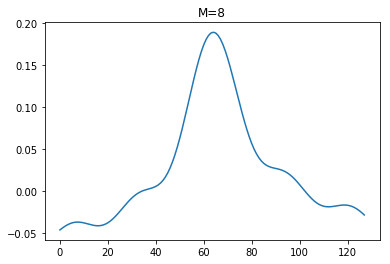

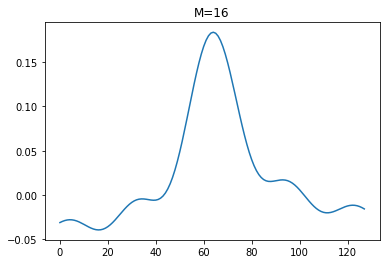

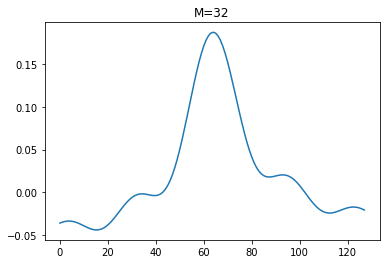

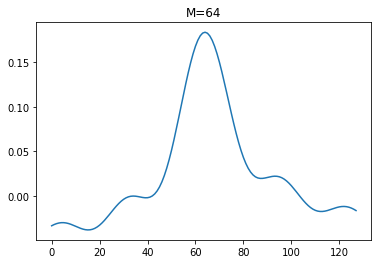

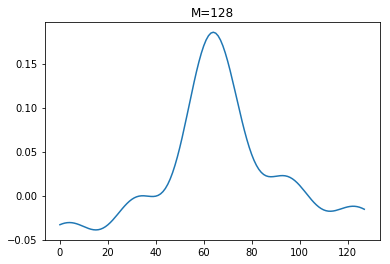

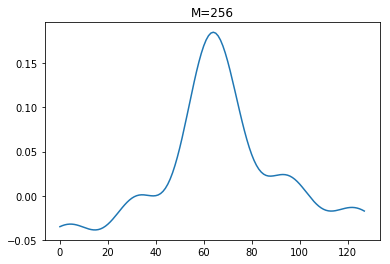

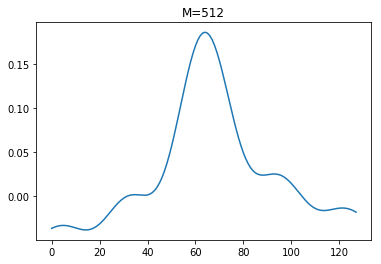

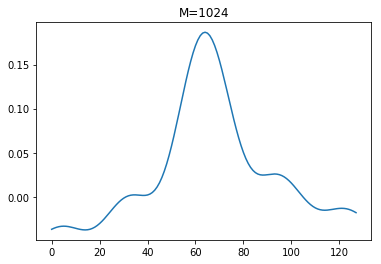

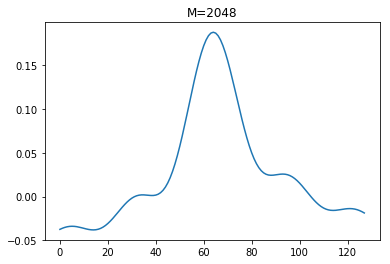

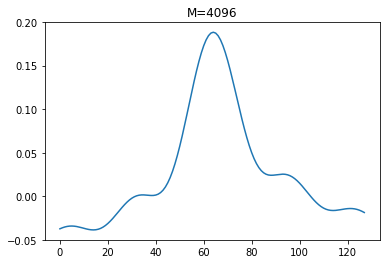

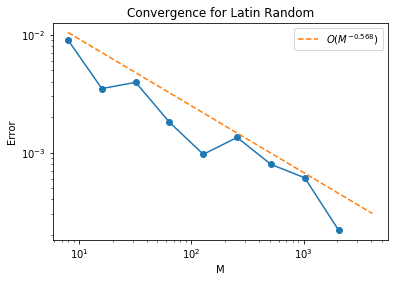

../configs/sine_niederreiter2/sine.xml


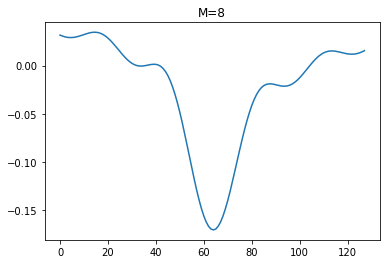

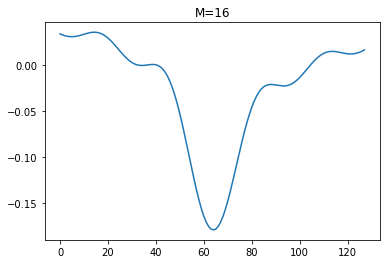

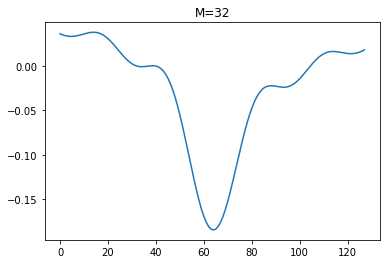

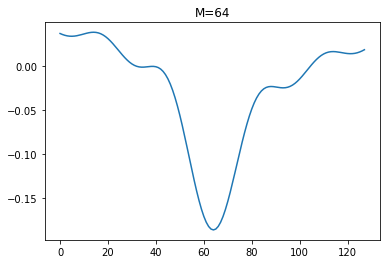

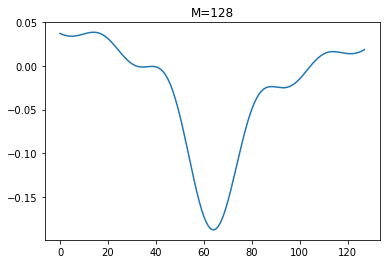

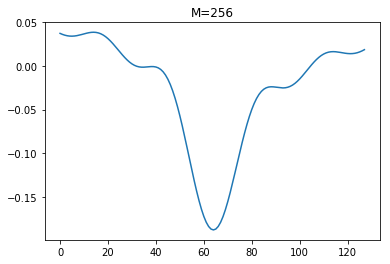

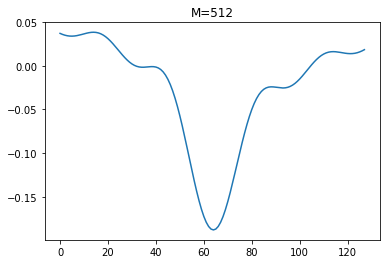

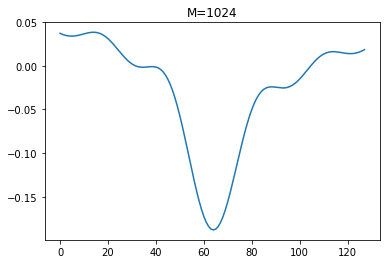

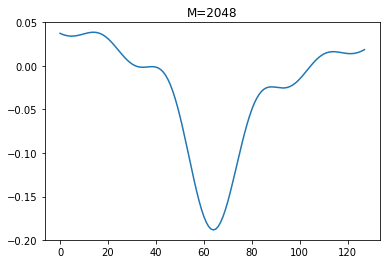

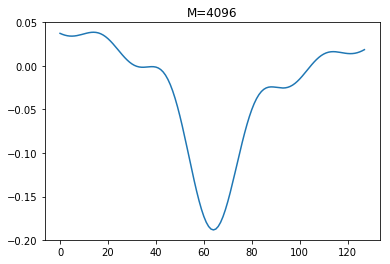

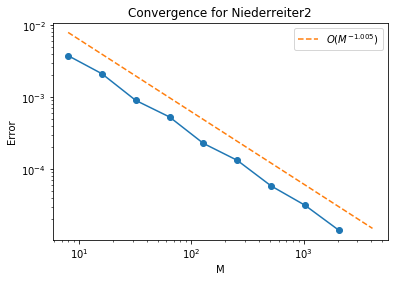

../configs/sine_halton/sine.xml


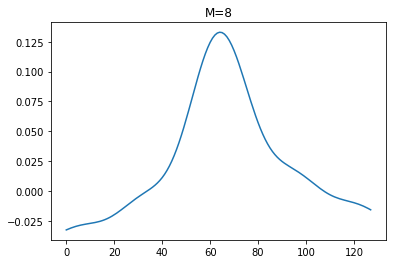

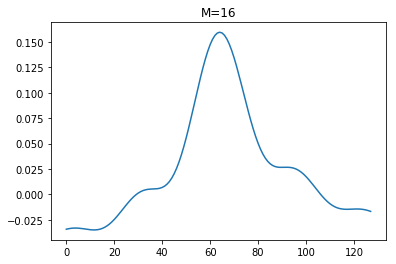

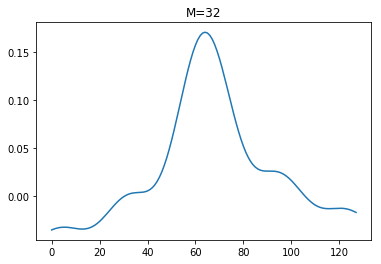

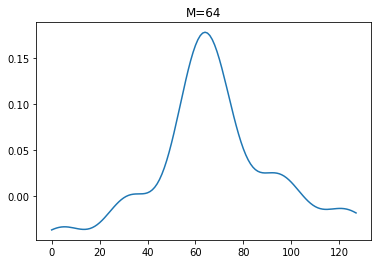

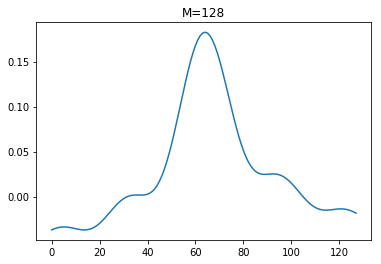

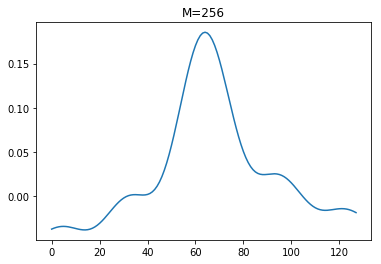

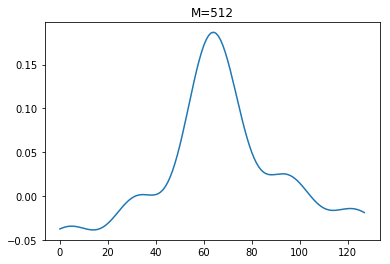

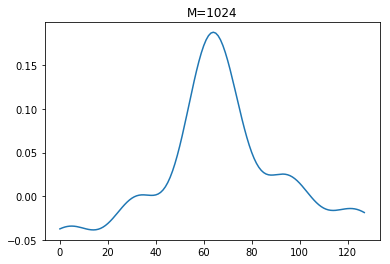

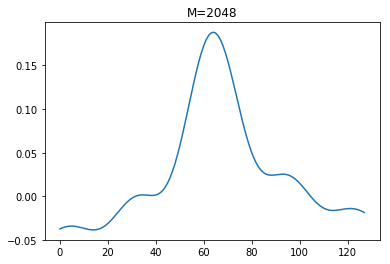

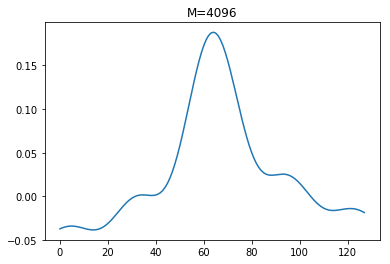

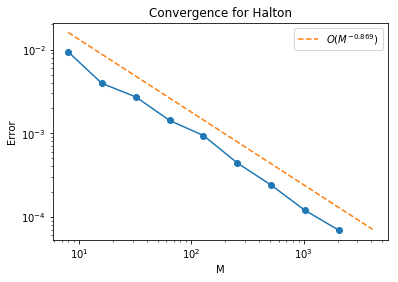

../configs/sine_sobol/sine.xml


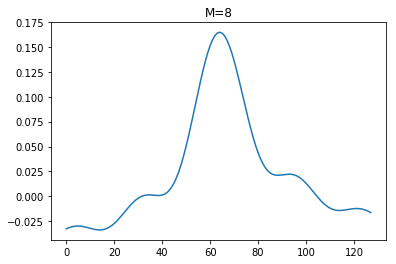

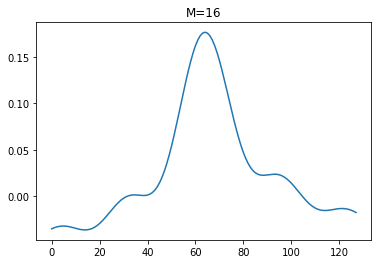

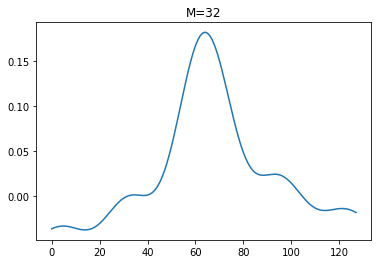

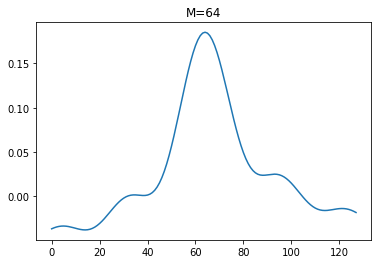

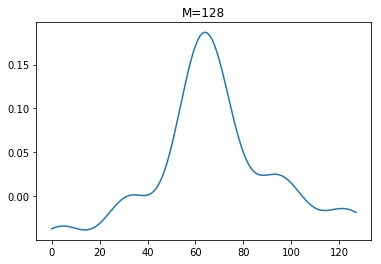

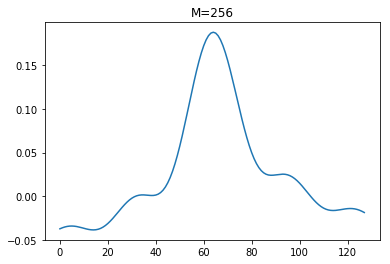

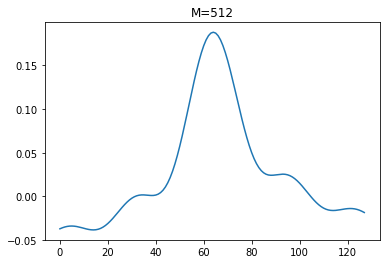

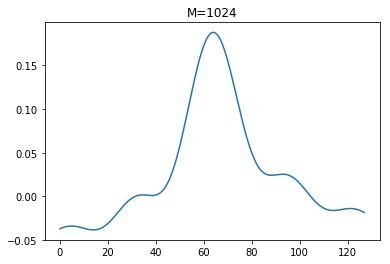

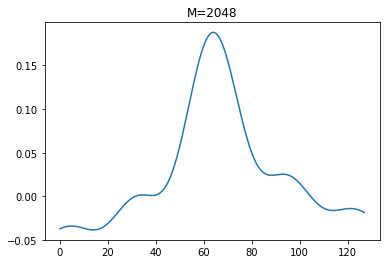

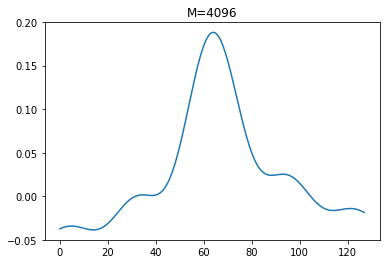

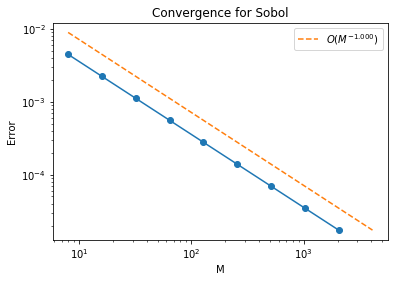

../configs/sine_monte_carlo/sine.xml


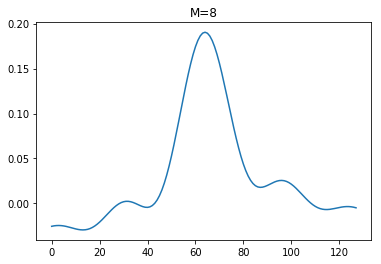

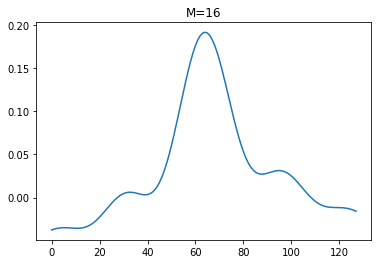

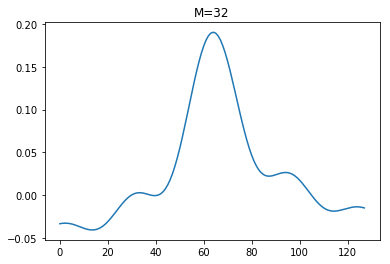

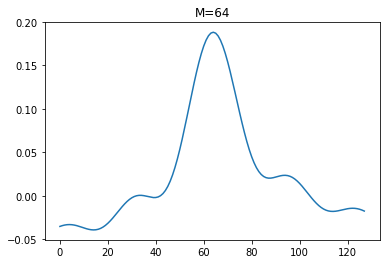

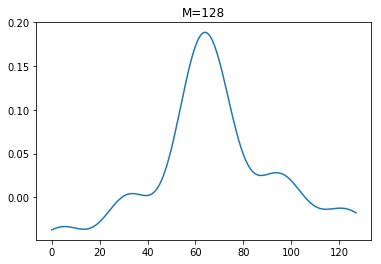

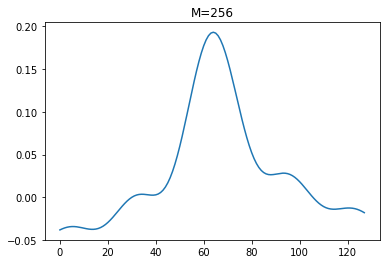

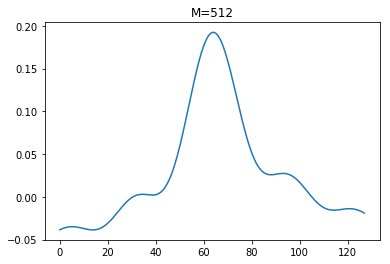

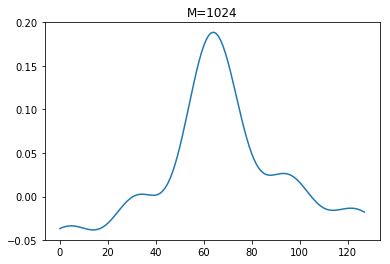

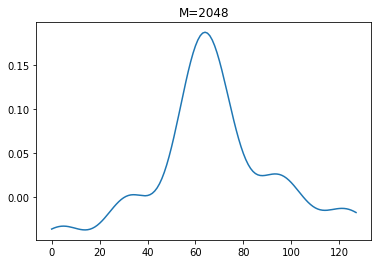

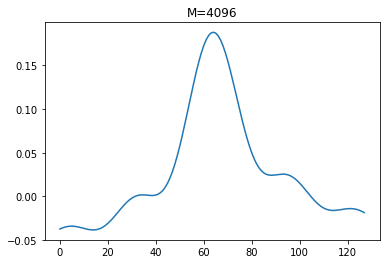

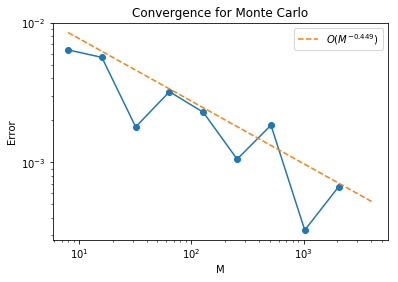

../configs/sine_latin_center/sine.xml


Exception: Error running alsvinncli.

 The command used was

	/home/kjetil/projects/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 8
'
----------------

The error output was:

----------------
b'
I4_UNIFORM - Fatal error!
  Input value of SEED = 0.
'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'

In [10]:
import glob

for basename in glob.glob("../configs/sine_*"):
    computeConvergence(basename + "/sine.xml")

In [5]:
import re
def computeConvergencePlotInSame(basename):
    name = re.search(r'sine_(.+)\/', basename).group(1)
    print(basename)
    name = name.replace("_", " ").title()
    
    N = 128
    display(HTML("<h1>%s</h1>" % name))
    try:
        r = alsvinn.run(name='test', base_xml=basename, dimension=[N,1,1], uq=True, samples=4096)
    except Exception as e:
        print (e)
        return
    Ms = 2**array(range(3,13))
    
    errors = []
    
    for M in Ms:
        mean = zeros((N))
        for k in range(M):
            mean += r.get_data('u', timestep=0, sample=k)
        mean /= M
        
       
        if M > Ms[0]:
            errors.append(sqrt(sum(abs(mean-meanPrev)**2)/mean.shape[0]))
        meanPrev = mean
    plt.loglog(Ms[:-1], errors, '-o', label=name)
    poly = polyfit(log(Ms[1:]), log(errors), 1)
    
    plt.loglog(Ms, exp(poly[1])*Ms**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
    plt.xlabel("M")
    plt.ylabel("Error")
    

    

../configs/sine_latin_random/sine.xml


../configs/sine_niederreiter2/sine.xml


../configs/sine_halton/sine.xml


../configs/sine_sobol/sine.xml


../configs/sine_monte_carlo/sine.xml


../configs/sine_latin_center/sine.xml


Error running alsvinncli.

 The command used was

	/home/kjetil/projects/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 8
'
----------------

The error output was:

----------------
b'
I4_UNIFORM - Fatal error!
  Input value of SEED = 0.
'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_faure/sine.xml


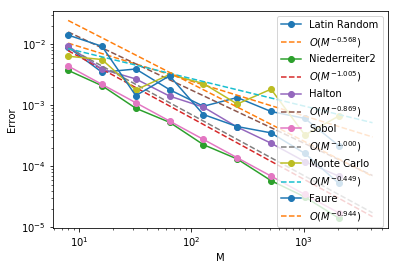

In [8]:
for basename in glob.glob("../configs/sine_*"):
    computeConvergencePlotInSame(basename + "/sine.xml")
plt.legend()
plt.show()

../configs/sine_latin_random/sine.xml


../configs/sine_niederreiter2/sine.xml


../configs/sine_halton/sine.xml


../configs/sine_sobol/sine.xml


../configs/sine_monte_carlo/sine.xml


../configs/sine_latin_center/sine.xml


Error running alsvinncli.

 The command used was

	/home/kjetil/projects/alsvinn/build/alsuqcli/alsuqcli test.xml

The output was:

----------------
b'omp max threads= 8
'
----------------

The error output was:

----------------
b'
I4_UNIFORM - Fatal error!
  Input value of SEED = 0.
'

----------------

Also check the log files 'alsvinncli_mpi_log_<n>.txt'
../configs/sine_faure/sine.xml


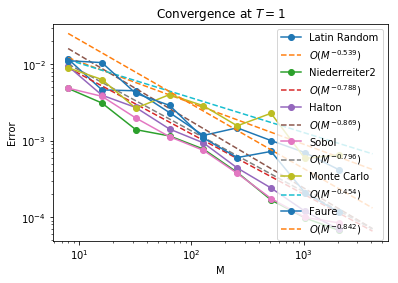

In [9]:
import re
def computeConvergencePlotInSameAfterTime(basename):
    name = re.search(r'sine_(.+)\/', basename).group(1)
    print(basename)
    name = name.replace("_", " ").title()
    
    N = 128
    display(HTML("<h1>%s</h1>" % name))
    try:
        r = alsvinn.run(name='test', base_xml=basename, dimension=[N,1,1], uq=True, samples=4096)
    except Exception as e:
        print (e)
        return
    Ms = 2**array(range(3,13))
    
    errors = []
    
    for M in Ms:
        mean = zeros((N))
        for k in range(M):
            mean += r.get_data('u', timestep=1, sample=k)
        mean /= M
        
       
        if M > Ms[0]:
            errors.append(sqrt(sum(abs(mean-meanPrev)**2)/mean.shape[0]))
        meanPrev = mean
    plt.loglog(Ms[:-1], errors, '-o', label=name)
    poly = polyfit(log(Ms[1:]), log(errors), 1)
    plt.title("Convergence at $T=1$")
    plt.loglog(Ms, exp(poly[1])*Ms**poly[0], '--', label='$O(M^{%.3f})$' % poly[0])
    plt.xlabel("M")
    plt.ylabel("Error")
    plt.legend()
    
for basename in glob.glob("../configs/sine_*"):
    computeConvergencePlotInSameAfterTime(basename + "/sine.xml")
plt.legend()
plt.show()